### Codes to set up Kaggle API, install additional packages

In [24]:
# Install packages if needed with this command:
# !pip install -r requirements.txt
import os
import kaggle
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# From here, add any libraries that you might need for the rest of your code
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda, BatchNormalization, Activation, Conv2D, MaxPooling2D, LeakyReLU, GlobalAveragePooling2D, Flatten, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from keras_tuner import HyperModel
from keras_tuner.tuners import BayesianOptimization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [25]:
# download data
data_dir = 'driver-inattention-detection-dataset'
if not os.path.isdir(data_dir):
    kaggle.api.dataset_download_files('zeyad1mashhour/driver-inattention-detection-dataset',
                                    path=data_dir, unzip=True)

# 1. Load dataset


In [26]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# read the file containing the class labels
with open(os.path.join(data_dir, 'train', '_classes.txt')) as f:
    classes = list(map(str.strip, f))

# read image paths and labels and store them in pandas dataframes
with open(os.path.join(data_dir, 'test', '_annotations.txt'), 'r') as f:
    df_test = pd.DataFrame(dict(img=os.path.join(data_dir, 'test', line.split()[0]),
                                label=classes[int(line.strip()[-1])]) for line in f)

with open(os.path.join(data_dir, 'valid', '_annotations.txt'), 'r') as f:
    df_val = pd.DataFrame(dict(img=os.path.join(data_dir, 'valid', line.split()[0]),
                               label=classes[int(line.strip()[-1])]) for line in f)

with open(os.path.join(data_dir, 'train', '_annotations.txt'), 'r') as f:
    df_train = pd.DataFrame(dict(img=os.path.join(data_dir, 'train', line.split()[0]),
                                 label=classes[int(line.strip()[-1])]) for line in f if len(line.split())>1)

# pre-processing parameters
image_unit_res = 8
img_height, img_width = 9*image_unit_res, 16*image_unit_res # 16:9 preserve aspect ratio
batch_size = 32

def add_noise(img):
    std_coeff = 50*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    img = np.clip(img, 0., 255.)
    return img

data_gen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

train_data = data_gen.flow_from_dataframe(
    df_train, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale')

val_data = data_gen.flow_from_dataframe(
    df_val, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale')

test_data = data_gen.flow_from_dataframe(
    df_test, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale')

Found 11948 validated image filenames belonging to 6 classes.
Found 1922 validated image filenames belonging to 6 classes.
Found 985 validated image filenames belonging to 6 classes.


# 2. Visualise data and plot data distribution

2a. Feature Encoding: Convert the **variables** using a proper function for one hot encoding

Found 11948 validated image filenames belonging to 6 classes.


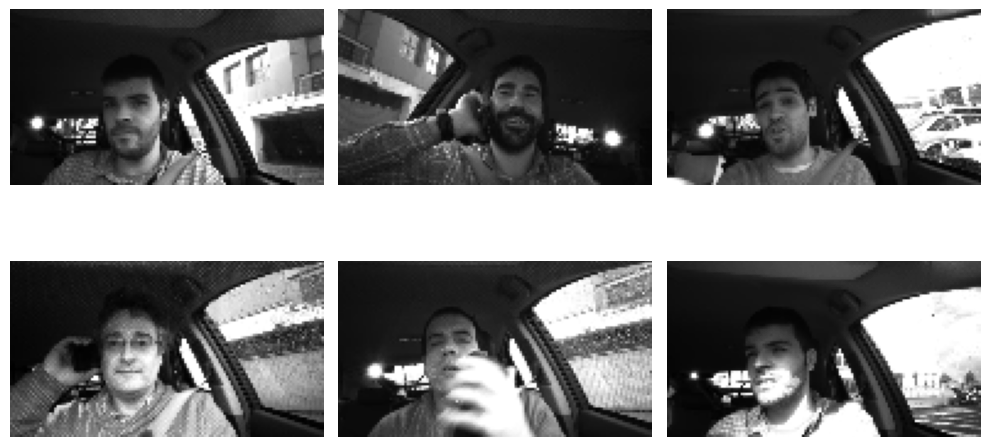

In [27]:
# Initialize ImageDataGenerator with rescaling
data_gen = ImageDataGenerator(rescale=1./255)

# Create a data generator from a dataframe
train_data = data_gen.flow_from_dataframe(
    df_train,
    x_col='img',
    y_col='label',
    target_size=(img_height, img_width),  # Resize images to a consistent size
    batch_size=batch_size, # Number of images to load per batch
    class_mode='categorical',  #Automatically operating One-Hot Encoding
    shuffle=True, # Shuffle the dataset at the beginning of each epoch
    color_mode='grayscale'
)

# Retrieve one batch of images and labels from the training data
# next(): Fetches the next batch of data.
# batch_labels: shape (batch_size, num_classes) with One-Hot Encoding
batch_images, batch_labels = next(train_data)

fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()  # Flatten the 2D array into a 1D array for easier iteration

# Display the first 6 images
for img, ax in zip(batch_images[:6], axes):
    ax.imshow(img.squeeze(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

2b. Data Visualisation: Display 15 images and their class labels

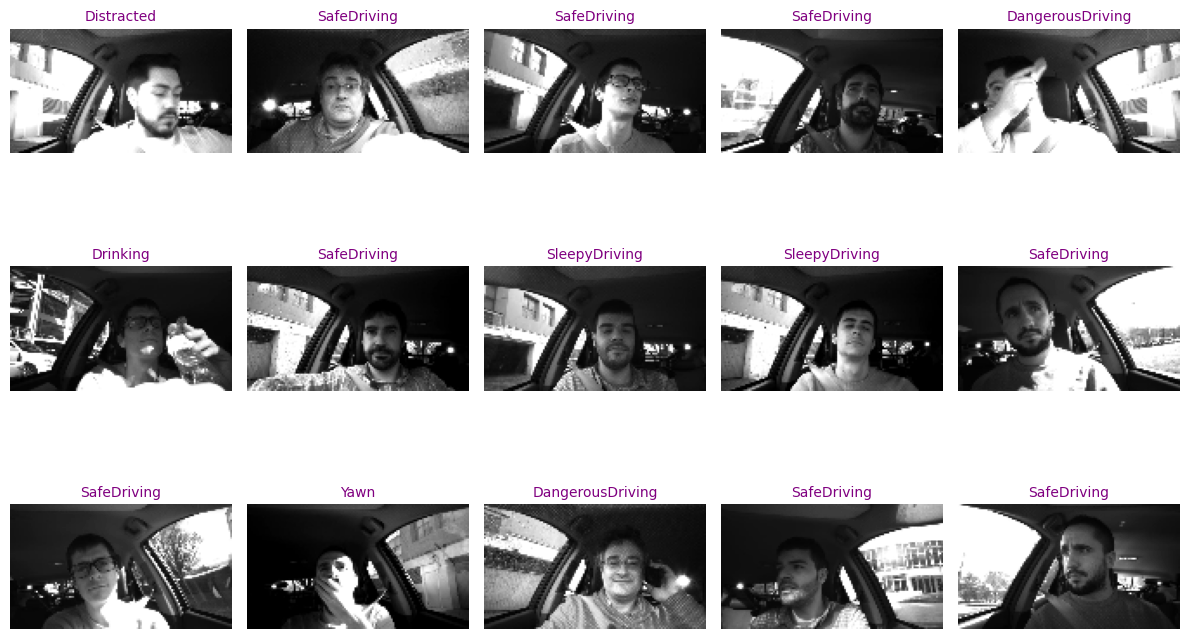

In [13]:
# Retrieve one batch of images and their corresponding labels from the data generator
batch_images, batch_labels = next(train_data)
class_names = [k for k, v in sorted(train_data.class_indices.items(), key=lambda item: item[1])] # Get the unique class names from the training DataFrame

fig, axes = plt.subplots(3, 5, figsize=(12, 8))
axes = axes.flatten()

# Loop through the first 15 images and their corresponding labels
for img, label, ax in zip(batch_images[:15], batch_labels[:15], axes):
    ax.imshow(img.squeeze(), cmap='gray')  # Display the image
    ax.axis('off')
    class_index = np.argmax(label) # Determine the predicted class by finding the index of the maximum value in the One-Hot Encoded label
    ax.set_title(class_names[class_index], fontsize=10, color="purple")

plt.tight_layout()
plt.savefig('15 images and their class labels.png', dpi=300)
plt.show()

2c. Plot Data Distribution: Create a bars plot to to visualise the class label of the dataset

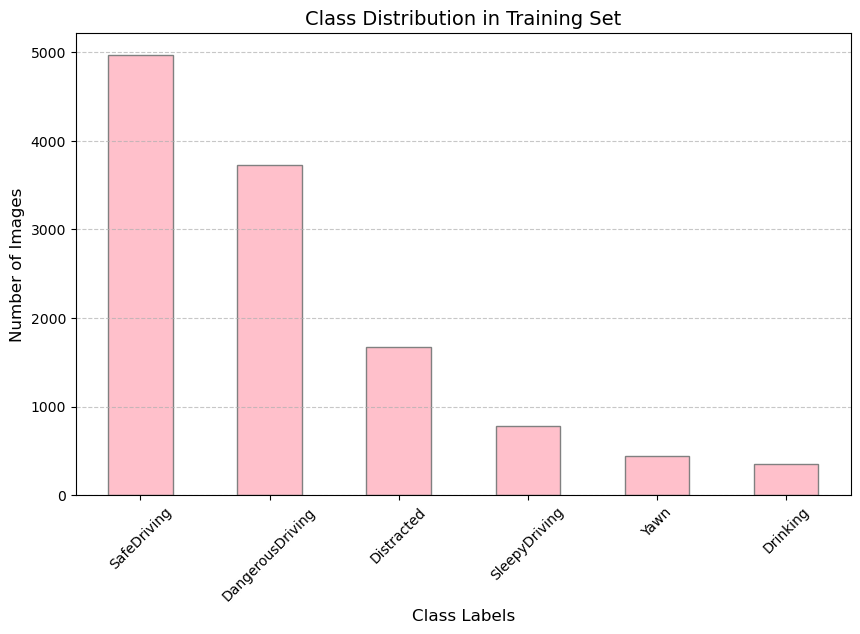

In [14]:
# Calculate the distribution of class labels in the dataset
label_counts = df_train['label'].value_counts()

# Create a bar plot to visualize the class distribution
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='pink', edgecolor='grey')

# Add titles and labels to the chart
plt.title("Class Distribution in Training Set", fontsize=14)
plt.xlabel("Class Labels", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)

# Adjust x-axis labels for better readability
plt.xticks(rotation=45)

# Add a grid to the y-axis to improve readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('Class Distribution in Training Set.png', dpi=300)
plt.show()

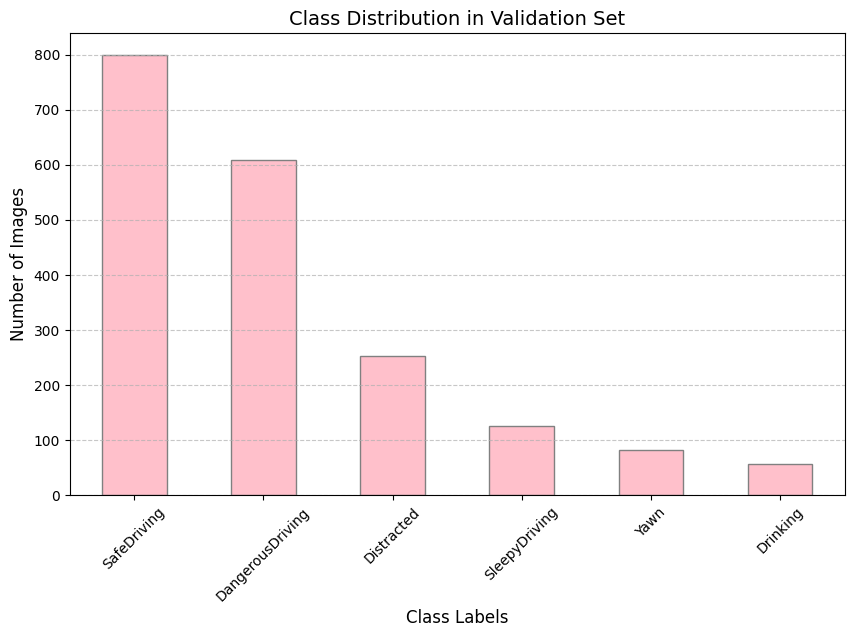

In [ ]:
# Calculate the distribution of class labels in the dataset
label_counts = df_val['label'].value_counts()

# Create a bar plot to visualize the class distribution
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='pink', edgecolor='grey')

# Add titles and labels to the chart
plt.title("Class Distribution in Validation Set", fontsize=14)
plt.xlabel("Class Labels", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)

# Adjust x-axis labels for better readability
plt.xticks(rotation=45)

# Add a grid to the y-axis to improve readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('Class Distribution in Validation Set.png', dpi=300)
plt.show()

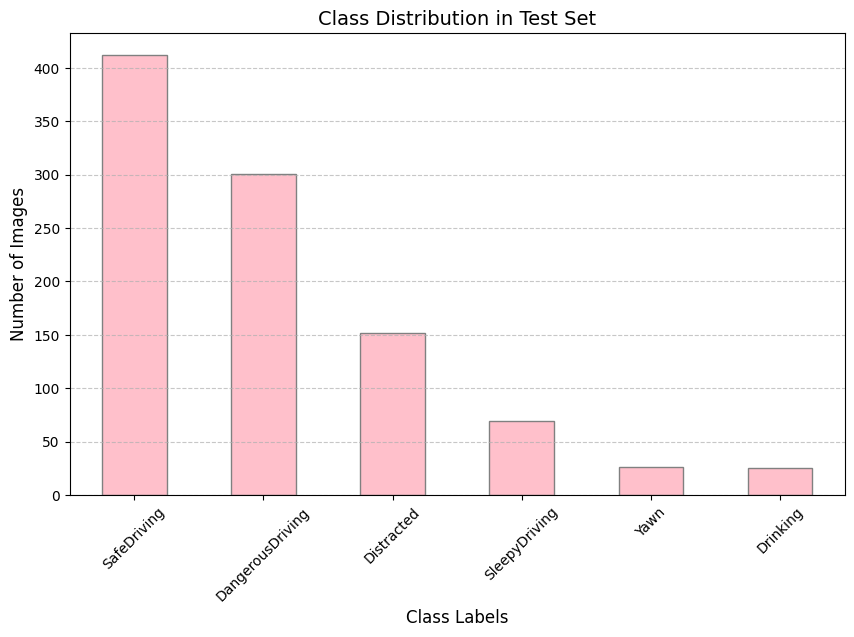

In [ ]:
# Calculate the distribution of class labels in the dataset
label_counts = df_test['label'].value_counts()

# Create a bar plot to visualize the class distribution
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='pink', edgecolor='grey')

# Add titles and labels to the chart
plt.title("Class Distribution in Test Set", fontsize=14)
plt.xlabel("Class Labels", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)

# Adjust x-axis labels for better readability
plt.xticks(rotation=45)

# Add a grid to the y-axis to improve readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('Class Distribution in Test Set.png', dpi=300)
plt.show()

In [ ]:
# downlaod images and figures
files.download('15 images and their class labels.png')
files.download('Class Distribution in Training Set.png')
files.download('Class Distribution in Validation Set.png')
files.download('Class Distribution in Test Set.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 3. Train and Evaluation functions

In [ ]:
# Create object for the model.
model = Sequential()

In [ ]:
#Add Convolution + Max Pooling each empty line corrseponds to the start of a new Convolution and Max pooling layer.
model.add(Conv2D(8,
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(72, 128, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(8,
                 kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(8,
                 kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Flatten the model in order to prepare for the 10-dimensional layer.
model.add(Flatten())

In [ ]:
# Turns the layer into a 10-dimensional space
model.add(Dense(10, activation='relu'))

In [ ]:
# Turns 10 dimensions to 6 logits.
# Here, we use softmax activation for multi-class classification.
model.add(Dense(6, activation='softmax'))

In [ ]:
# Compiles the model
# Compile the model.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 70, 126, 8)          │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 35, 63, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 33, 61, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 30, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 28, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 14, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           7,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,164 (35.80 KB)

 Trainable params: 9,164 (35.80 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model for 10 epochs with a batch size of 32.
history = model.fit(train_data,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_data))

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 27s 65ms/step - accuracy: 0.4655 - loss: 1.3953 - val_accuracy: 0.4948 - val_loss: 1.9177
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.6575 - loss: 0.9153 - val_accuracy: 0.5375 - val_loss: 1.8692
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.7288 - loss: 0.7533 - val_accuracy: 0.5739 - val_loss: 1.3678
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.7576 - loss: 0.6759 - val_accuracy: 0.5687 - val_loss: 1.6657
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.7738 - loss: 0.6270 - val_accuracy: 0.5947 - val_loss: 1.2783
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.7902 - loss: 0.5848 - val_accuracy: 0.6243 - val_loss: 1.3846
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.7995 - loss: 0.5676 - val_accuracy: 0.6264 - val_loss: 1.3855
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.8068 - loss: 0.5385 - val_accurac

In [ ]:
# Get model predictions (probabilities) for the validation and test sets:

# Get predictions for the validation and test sets
y_val_pred = model.predict(val_data)
y_test_pred = model.predict(test_data)

# Retrieve true labels directly from the generator attributes:
y_val_true_labels = val_data.labels
y_test_true_labels = test_data.labels

# Convert to class labels
y_val_pred_labels = np.argmax(y_val_pred, axis=1)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Calculate accuracy as the mean of correct predictions
val_accuracy = np.mean(y_val_pred_labels == y_val_true_labels)
test_accuracy = np.mean(y_test_pred_labels == y_test_true_labels)

print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)

61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step
Validation Accuracy: 0.6279916753381893
Test Accuracy: 0.6284263959390863


In [ ]:
# Since epochs will be used for the x-axis, the following section allows us to do this.
epochs = range(1, len(history.history['loss']) + 1)

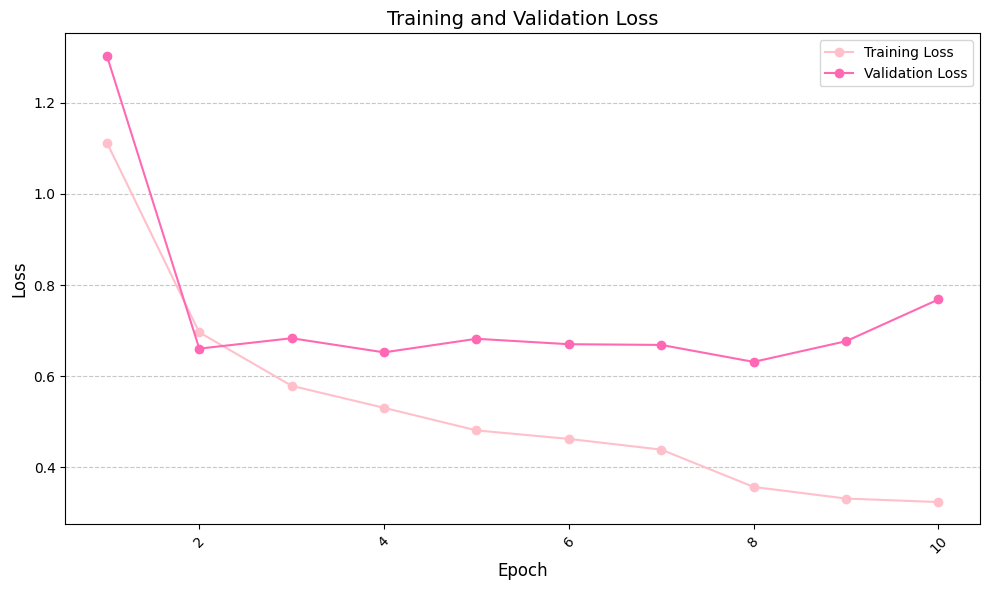

In [ ]:
# Create a figure with the same size as the class distribution plot
plt.figure(figsize=(10, 6))

# Plot training and validation loss with pink hues and markers for clarity
plt.plot(epochs, history.history['loss'], color='pink', linestyle='-', marker='o', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], color='hotpink', linestyle='-', marker='o', label='Validation Loss')

# Set title and axis labels with matching font sizes
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a grid to the y-axis for improved readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the legend
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig('Baseline Model Training and Validation Loss.png', dpi=300)
plt.show()

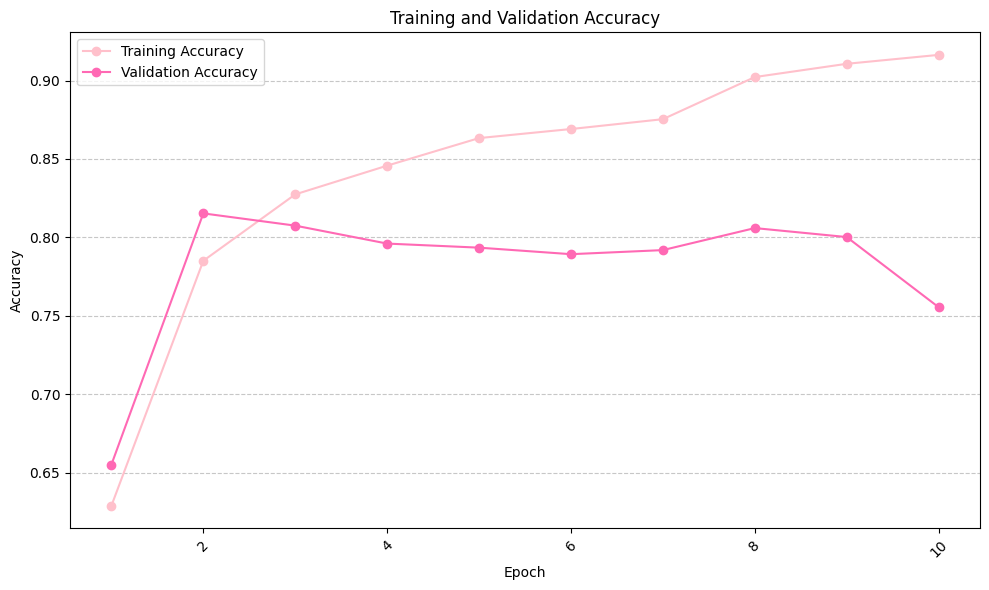

In [ ]:
plt.figure(figsize=(10, 6))  # Ensure the same figure size as the other plot

plt.plot(epochs, history.history['accuracy'], color='pink', linestyle='-', marker = 'o', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], color='hotpink', linestyle='-', marker = 'o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.xticks(rotation=45)                  # Rotate x-axis labels for consistency
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid on the y-axis
plt.tight_layout()                       # Adjust layout to prevent overlap
plt.savefig('Baseline Model Training and Validation Accuracy.png', dpi=300)
plt.show()

In [ ]:
# Validation Set Performance

# Retrieve true labels and predicted probabilities, then convert predictions to class labels.
y_val_true_int = val_data.labels
y_val_pred_int = np.argmax(y_val_pred, axis=1)

# Calculate performance measures for the validation set.
# Weighted has been chosen to reflect the actual class distribution.
val_accuracy = accuracy_score(y_val_true_int, y_val_pred_int)
val_precision = precision_score(y_val_true_int, y_val_pred_int, average='weighted', zero_division=0)
val_recall = recall_score(y_val_true_int, y_val_pred_int, average='weighted')
val_f1 = f1_score(y_val_true_int, y_val_pred_int, average='weighted')

print(" --- Validation Set Performance: ---")
print("Accuracy: {:.2f}".format(val_accuracy))
print("Precision: {:.2f}".format(val_precision))
print("Recall: {:.2f}".format(val_recall))
print("F1 Score: {:.2f}".format(val_f1))


# Test Set Performance

# Retrieve true labels and predicted probabilities, then convert predictions to class labels.
# Weighted has been chosen to reflect the actual class distribution.
y_test_true_int = test_data.labels
y_test_pred_int = np.argmax(y_test_pred, axis=1)

# Calculate performance measures for the test set.
test_accuracy = accuracy_score(y_test_true_int, y_test_pred_int)
test_precision = precision_score(y_test_true_int, y_test_pred_int, average='weighted', zero_division=0)
test_recall = recall_score(y_test_true_int, y_test_pred_int, average='weighted')
test_f1 = f1_score(y_test_true_int, y_test_pred_int, average='weighted')

print("--- Test Set Performance: ---")
print("Accuracy: {:.2f}".format(test_accuracy))
print("Precision: {:.2f}".format(test_precision))
print("Recall: {:.2f}".format(test_recall))
print("F1 Score: {:.2f}".format(test_f1))


 --- Validation Set Performance: ---
Accuracy: 0.63
Precision: 0.68
Recall: 0.63
F1 Score: 0.62
--- Test Set Performance: ---
Accuracy: 0.63
Precision: 0.69
Recall: 0.63
F1 Score: 0.62


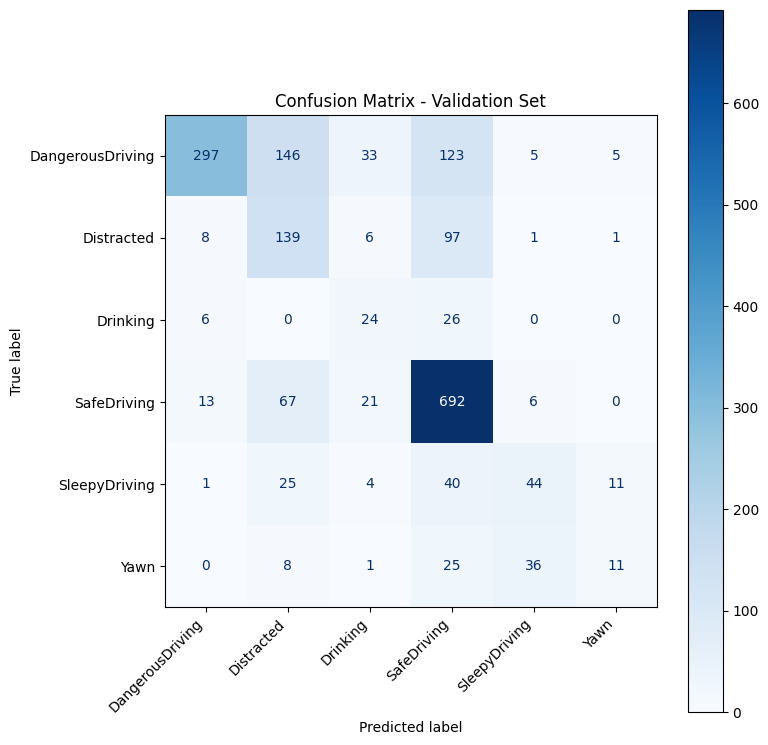

In [ ]:
# Retrieve true and predicted integer labels.
y_val_true_int = val_data.labels
y_val_pred_int = np.argmax(y_val_pred, axis=1)

# Compute the confusion matrix.
cm = confusion_matrix(y_val_true_int, y_val_pred_int)

# Extract class names in the correct order.
class_names = [k for k, v in sorted(val_data.class_indices.items(), key=lambda item: item[1])]

# Create a figure and axis with an adjusted size.
fig, ax = plt.subplots(figsize=(8, 8))

# Create the confusion matrix display.
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp_val.plot(cmap=plt.cm.Blues, ax=ax)

# Rotate x-axis labels and adjust their alignment.
plt.xticks(rotation=45, ha='right')
plt.title('Confusion Matrix - Validation Set')

# Adjust layout so labels have enough space.
plt.tight_layout()
plt.savefig('Baseline Model Confusion Matrix - Validation Set.png', dpi=300)
plt.show()


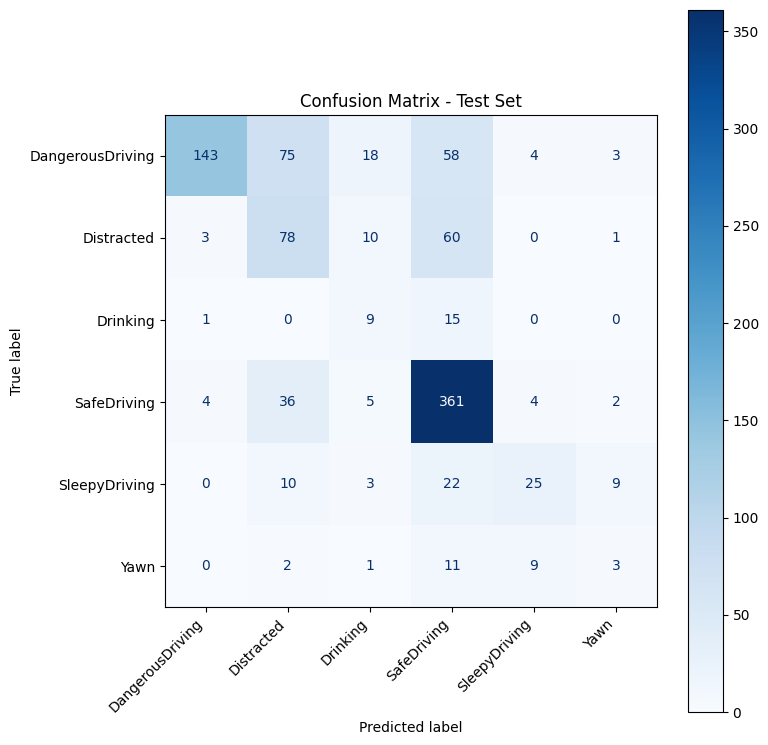

In [ ]:
# Retrieve true and predicted integer labels.
y_test_true_int = test_data.labels
y_test_pred_int = np.argmax(y_test_pred, axis=1)

# Compute the confusion matrix.
cm = confusion_matrix(y_test_true_int, y_test_pred_int)

# Extract class names in the correct order.
class_names = [k for k, v in sorted(test_data.class_indices.items(), key=lambda item: item[1])]

# Create a figure and axis with an adjusted size.
fig, ax = plt.subplots(figsize=(8, 8))

# Create the confusion matrix display.
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp_test.plot(cmap=plt.cm.Blues, ax=ax)

# Rotate x-axis labels and adjust their alignment.
plt.xticks(rotation=45, ha='right')
plt.title('Confusion Matrix - Test Set')

# Adjust layout so labels have enough space.
plt.tight_layout()
plt.savefig('Baseline Model Confusion Matrix - Test Set.png', dpi=300)
plt.show()

<ipython-input-50-51cb9b418e4a>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


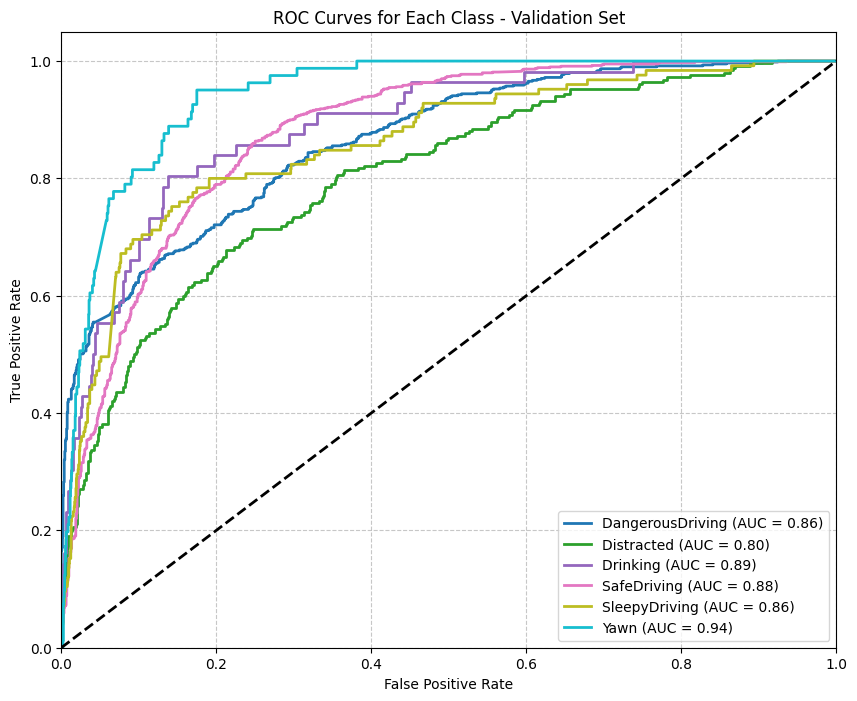

In [ ]:
# Determine number of classes from the validation set.
n_classes = len(np.unique(val_data.labels))

# Binarize the true labels for the validation set.
y_val_true_bin = label_binarize(val_data.labels, classes=range(n_classes))

# Compute ROC curve and AUC for each class.
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_true_bin[:, i], y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Extract class names in the correct order.
class_names = [k for k, v in sorted(val_data.class_indices.items(), key=lambda item: item[1])]

# Plot ROC curves for each class.
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', n_classes)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             color=colors(i),
             lw=2,
             label='{} (AUC = {:.2f})'.format(class_names[i], roc_auc[i]))

# Plot the random chance line.
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class - Validation Set')
plt.legend(loc="lower right")
plt.grid(alpha=0.7, linestyle='--')
plt.savefig('Baseline Model ROC Curves - Validation Set.png', dpi=300)
plt.show()

<ipython-input-51-1148ba1c68ab>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes_test)


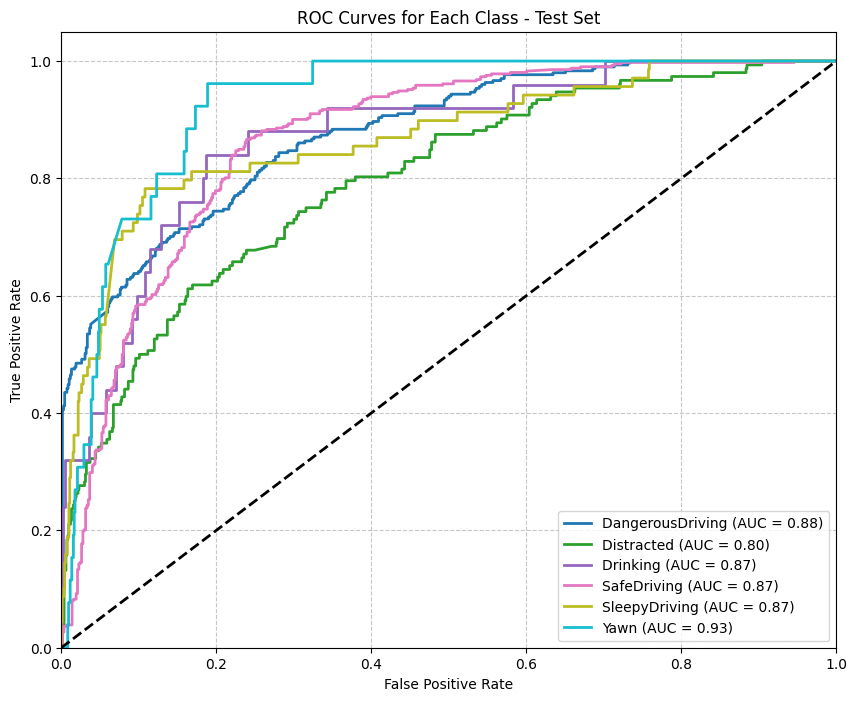

In [ ]:
# Determine number of classes from the test set.
n_classes_test = len(np.unique(test_data.labels))

# Binarize the true labels for the test set.
y_test_true_bin = label_binarize(test_data.labels, classes=range(n_classes_test))

# Compute ROC curve and AUC for each class.
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes_test):
    fpr[i], tpr[i], _ = roc_curve(y_test_true_bin[:, i], y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Extract class names in the correct order.
class_names = [k for k, v in sorted(test_data.class_indices.items(), key=lambda item: item[1])]

# Plot ROC curves for each class.
plt.figure(figsize=(10, 8))
# Use a colormap with as many distinct colors as classes.
colors = plt.cm.get_cmap('tab10', n_classes_test)

for i in range(n_classes_test):
    plt.plot(fpr[i], tpr[i],
             color=colors(i),
             lw=2,
             label='{} (AUC = {:.2f})'.format(class_names[i], roc_auc[i]))

# Plot the random chance line.
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class - Test Set')
plt.legend(loc="lower right")
plt.grid(alpha=0.7, linestyle='--')
plt.savefig('Baseline Model ROC Curves - Test Set.png', dpi=300)
plt.show()

In [ ]:
# download the figures
files.download('Baseline Model Training and Validation Loss.png')
files.download('Baseline Model Training and Validation Accuracy.png')
files.download('Baseline Model Confusion Matrix - Validation Set.png')
files.download('Baseline Model Confusion Matrix - Test Set.png')
files.download('Baseline Model ROC Curves - Validation Set.png')
files.download('Baseline Model ROC Curves - Test Set.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 4. Model Improvement

4.1. Improve the deep-layer model with new optimizers, dropout, regularization, and learning rate

In [ ]:
deep_opt = Sequential()

#Increase the number of filters and filter size to be more complex
deep_opt.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=(72, 128, 1)))
deep_opt.add(BatchNormalization())
deep_opt.add(MaxPooling2D(pool_size=(2, 2)))

deep_opt.add(Conv2D(128, kernel_size=(5, 5), activation='relu'))
deep_opt.add(MaxPooling2D(pool_size=(2, 2)))

deep_opt.add(Conv2D(256, kernel_size=(5, 5), activation='relu'))
deep_opt.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the model to prepare for the 64-dimensional layer.
deep_opt.add(Flatten())

# Turns the layer into a 64-dimensional space, regularisation, and adds dropout rate
deep_opt.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
deep_opt.add(Dropout(0.5))
# Turns 64 dimensions to 6 logits
deep_opt.add(Dense(6, activation='softmax'))

# Replace optimizer 'adam' to 'rmsprop'
deep_opt.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

deep_opt.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 68, 124, 64)         │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 68, 124, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 34, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 30, 58, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 15, 29, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 11, 25, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 5, 12, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 15360)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,966,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,993,286 (11.42 MB)

 Trainable params: 2,993,158 (11.42 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = deep_opt.fit(train_data,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_data),
                    callbacks=[early_stop, reduce_lr])

Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 32s 71ms/step - accuracy: 0.5014 - loss: 2.7530 - val_accuracy: 0.7164 - val_loss: 1.2839 - learning_rate: 0.0010
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.8219 - loss: 0.5696 - val_accuracy: 0.8132 - val_loss: 0.7037 - learning_rate: 0.0010
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.8710 - loss: 0.4376 - val_accuracy: 0.7955 - val_loss: 0.6752 - learning_rate: 0.0010
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.9046 - loss: 0.3420 - val_accuracy: 0.7154 - val_loss: 0.8406 - learning_rate: 0.0010
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.9225 - loss: 0.2930 - val_accuracy: 0.7674 - val_loss: 0.7428 - learning_rate: 0.0010
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.9314 - loss: 0.2596 - val_accuracy: 0.7248 - val_loss: 0.8580 - learning_rate: 0.0010
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.9542 - l

4.2. Improve the moderate-layer model with new optimizers, dropout, regularization, and learning rate

In [ ]:
moderate_opt = Sequential()

#Increase the number of filters and filter size to be more complex
moderate_opt.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=(72, 128, 1)))
moderate_opt.add(BatchNormalization())
moderate_opt.add(MaxPooling2D(pool_size=(2, 2)))

moderate_opt.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
moderate_opt.add(MaxPooling2D(pool_size=(2, 2)))

moderate_opt.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
moderate_opt.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the model to prepare for the 64-dimensional layer.
moderate_opt.add(Flatten())

# Turns the layer into a 64-dimensional space, regularisation, and adds dropout rate
moderate_opt.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
moderate_opt.add(Dropout(0.5))
# Turns 64 dimensions to 6 logits
moderate_opt.add(Dense(6, activation='softmax'))

# Replace optimizer 'adam' to 'rmsprop'
moderate_opt.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

moderate_opt.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 68, 124, 16)         │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 68, 124, 16)         │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 34, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 60, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 14, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 7, 14, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │         401,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 425,478 (1.62 MB)

 Trainable params: 425,446 (1.62 MB)

 Non-trainable params: 32 (128.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = moderate_opt.fit(train_data,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_data),
                    callbacks=[early_stop, reduce_lr])

Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 28s 67ms/step - accuracy: 0.5321 - loss: 1.3841 - val_accuracy: 0.6550 - val_loss: 1.3035 - learning_rate: 0.0010
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.7701 - loss: 0.7268 - val_accuracy: 0.8153 - val_loss: 0.6605 - learning_rate: 0.0010
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.8249 - loss: 0.5831 - val_accuracy: 0.8075 - val_loss: 0.6833 - learning_rate: 0.0010
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.8494 - loss: 0.5252 - val_accuracy: 0.7960 - val_loss: 0.6523 - learning_rate: 0.0010
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.8612 - loss: 0.4815 - val_accuracy: 0.7934 - val_loss: 0.6821 - learning_rate: 0.0010
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.8700 - loss: 0.4600 - val_accuracy: 0.7893 - val_loss: 0.6702 - learning_rate: 0.0010
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.8770 - l

4.3. Plotting the ROC curve with the AUC score

61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step


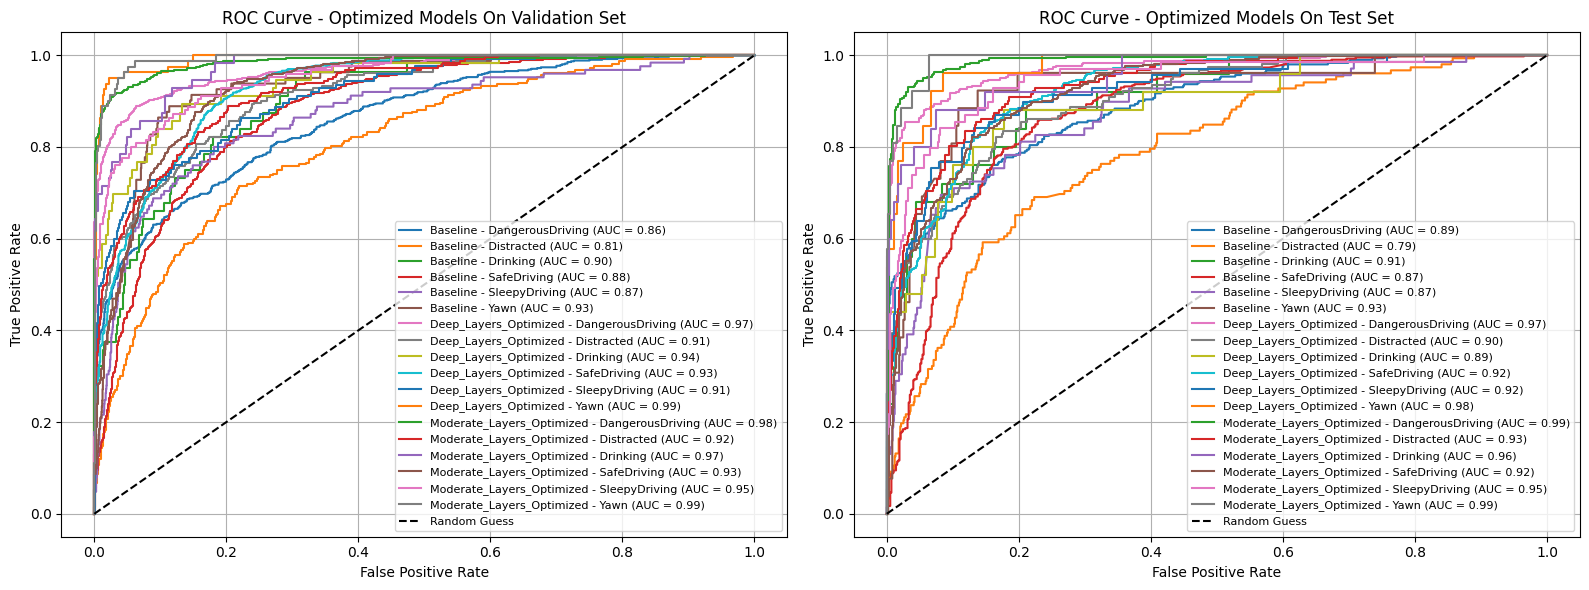

In [ ]:
# Retrieve class names from dataset
class_names = [k for k, v in sorted(val_data.class_indices.items(), key=lambda item: item[1])]
n_classes = len(class_names)

# Binarize the true labels
y_val_true_bin = label_binarize(val_data.labels, classes=range(n_classes))
y_test_true_bin = label_binarize(test_data.labels, classes=range(n_classes))

# Get predictions for validation and test sets
y_val_pred_baseline_bin = model.predict(val_data)
y_val_pred_improved3_bin = deep_opt.predict(val_data)
y_val_pred_improved4_bin = moderate_opt.predict(val_data)

y_test_pred_baseline_bin = model.predict(test_data)
y_test_pred_improved3_bin = deep_opt.predict(test_data)
y_test_pred_improved4_bin = moderate_opt.predict(test_data)

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Define model names and predictions for easy iteration
model_names = ['Baseline', 'Deep_Layers_Optimized', 'Moderate_Layers_Optimized']
val_predictions = [y_val_pred_baseline_bin, y_val_pred_improved3_bin, y_val_pred_improved4_bin]
test_predictions = [y_test_pred_baseline_bin, y_test_pred_improved3_bin, y_test_pred_improved4_bin]

# ---- Subplot 1: Validation Set ROC Curves ----
for model_name, y_pred_bin in zip(model_names, val_predictions):
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_val_true_bin[:, i], y_pred_bin[:, i])
        auc_score = auc(fpr, tpr)
        axes[0].plot(fpr, tpr, label=f'{model_name} - {class_name} (AUC = {auc_score:.2f})')

axes[0].plot([0, 1], [0, 1], 'k--', label='Random Guess')
axes[0].set_title("ROC Curve - Optimized Models On Validation Set")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend(loc="lower right", fontsize=8)
axes[0].grid(True)

# ---- Subplot 2: Test Set ROC Curves ----
for model_name, y_pred_bin in zip(model_names, test_predictions):
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_test_true_bin[:, i], y_pred_bin[:, i])
        auc_score = auc(fpr, tpr)
        axes[1].plot(fpr, tpr, label=f'{model_name} - {class_name} (AUC = {auc_score:.2f})')

axes[1].plot([0, 1], [0, 1], 'k--', label='Random Guess')
axes[1].set_title("ROC Curve - Optimized Models On Test Set")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend(loc="lower right", fontsize=8)
axes[1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('ROC Curve on Optimized Models.png', dpi=300)
plt.show()

4.4. Performance measures of all the previous models

In [ ]:
# Function to compute performance measures
def compute_metrics(y_true, y_pred, model_name, dataset):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return [accuracy, precision, recall, f1]

# Retrieve true labels
y_val_true = val_data.labels
y_test_true = test_data.labels

# Convert predictions to class labels
y_val_pred_baseline = np.argmax(model.predict(val_data), axis=1)
y_val_pred_deep_opt = np.argmax(deep_opt.predict(val_data), axis=1)
y_val_pred_moderate_opt = np.argmax(moderate_opt.predict(val_data), axis=1)

y_test_pred_baseline = np.argmax(model.predict(test_data), axis=1)
y_test_pred_deep_opt = np.argmax(deep_opt.predict(test_data), axis=1)
y_test_pred_moderate_opt = np.argmax(moderate_opt.predict(test_data), axis=1)

# Compute metrics for all models and datasets
baseline_val_metrics = compute_metrics(y_val_true, y_val_pred_baseline, "Baseline", "Validation")
deep_opt_val_metrics = compute_metrics(y_val_true, y_val_pred_deep_opt, "Deep_Optimized", "Validation")
moderate_opt_val_metrics = compute_metrics(y_val_true, y_val_pred_moderate_opt, "Moderate_Optimized", "Validation")

baseline_test_metrics = compute_metrics(y_test_true, y_test_pred_baseline, "Baseline", "Test")
deep_opt_test_metrics = compute_metrics(y_test_true, y_test_pred_deep_opt, "Deep_Optimized", "Test")
moderate_opt_test_metrics = compute_metrics(y_test_true, y_test_pred_moderate_opt, "Moderate_Optimized", "Test")

# Create DataFrame to compare performance
metrics_table = pd.DataFrame(
    [baseline_val_metrics,
     deep_opt_val_metrics, moderate_opt_val_metrics,
     baseline_test_metrics,
     deep_opt_test_metrics, moderate_opt_test_metrics],
    columns=["Accuracy", "Precision", "Recall", "F1-Score"],
    index=["Baseline (Val)", "Deep_Optimized (Val)", "Moderate_Optimized (Val)",
           "Baseline (Test)", "Deep_Optimized (Test)", "Moderate_Optimized (Test)"]
)

# Display the table
print("\nPerformance Comparison Table:")
print(metrics_table)

61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step

Performance Comparison Table:
                           Accuracy  Precision    Recall  F1-Score
Baseline (Val)             0.612903   0.665897  0.612903  0.610057
Deep_Optimized (Val)       0.793444   0.808811  0.793444  0.794527
Moderate_Optimized (Val)   0.806452   0.808328  0.806452  0.804741
Baseline (Test)            0.638579   0.685947  0.638579  0.637325
Deep_Optimized (Test)      0.781726   0.807198  0.781726  0.782749
Moderate_Optimized (Test)  0.780711   0.779829  0.780711  0.776743


In [ ]:
# download the figures
files.download('ROC Curve on Optimized Models.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4.8. Tuning parameter techniques

In [ ]:
#Baseline model function
def build_tuning_model(filter, kernel_size, dense_units, optimizer, activation, dropout_rate, regularizer=None):
    model = Sequential()

    model.add(Conv2D(filter, kernel_size=kernel_size, activation=activation, input_shape=(72, 128, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filter, kernel_size=kernel_size, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filter, kernel_size=(3, 3), activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())


    model.add(Dense(10, activation=activation, kernel_regularizer=regularizer))
    model.add(Dropout(dropout_rate))

    model.add(Dense(6, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

#Tuning the layers
def layer_tuning_model(training_set, val_set):
    settings = []
    results = []

    filters_list = [16, 32, 64]
    kernel_sizes = [(3,3), (5,5)]
    dense_neurons = [64, 128]

    for filter in filters_list:
        for kernel_size in kernel_sizes:
            for dense_units in dense_neurons:

                print(f"\nTraining with Filters={filter}, Kernel={kernel_size}, Dense={dense_units}")

                model = build_tuning_model(filter=filter,
                                           kernel_size=kernel_size,
                                           dense_units=dense_units,
                                           optimizer='adam',
                                           activation='relu',
                                           dropout_rate=0.0,
                                           regularizer=None)
                history = model.fit(training_set, validation_data=val_set, epochs=10)

                settings.append({
                    'filters': filter,
                    'kernel_size': kernel_size,
                    'dense_units': dense_units
                })

                results.append({
                    'accuracy': history.history['accuracy'][-1],
                    'val_accuracy': history.history['val_accuracy'][-1],
                    'loss': history.history['loss'][-1],
                    'val_loss': history.history['val_loss'][-1]
                })
    val_accuracies = [res['val_accuracy'] for res in results]
    best_ind = val_accuracies.index(max(val_accuracies))
    best_result = settings[best_ind]
    best_setting = results[best_ind]

    return best_result, best_setting

#Tuning the optimizers
def optimizer_tuning_model(training_set, val_set):
    settings = []
    results = []

    optimizers = {'adam': Adam,
                'rmsprop': RMSprop,
                'sgd': SGD}
    activations = ['relu', 'leakyrelu']
    regularizer_list = [regularizers.l2(0.0001),
                        regularizers.l2(0.001),
                        regularizers.l1_l2(l1=0.001, l2=0.001)]
    dropout_rates = [0.3, 0.5]

    for opt_name, optimizer in optimizers.items():
        for activation in activations:
            for regularizer in regularizer_list:
                for dropout in dropout_rates:

                    print(f"\nTraining with Optimizers={opt_name}, Activations={activation}, Regularizers={regularizer}, Dropout_rates={dropout}")

                    act_func = LeakyReLU(alpha=0.1) if activation == 'leakyrelu' else activation

                    model = build_tuning_model(filter=8, kernel_size=(3, 3),
                                               dense_units=64,
                                               optimizer=optimizer,
                                               activation=act_func,
                                               dropout_rate=dropout,
                                               regularizer=regularizer)
                    history = model.fit(training_set, validation_data=val_set, epochs=10)

                    settings.append({
                        'optimizers': opt_name,
                        'activations': activation,
                        'regularizers': str(regularizer),
                        'dropout_rates': dropout
                        })
                    results.append({
                        'accuracy': history.history['accuracy'][-1],
                        'val_accuracy': history.history['val_accuracy'][-1],
                        'loss': history.history['loss'][-1],
                        'val_loss': history.history['val_loss'][-1]
                        })

    val_accuracies = [res['val_accuracy'] for res in results]
    best_ind = val_accuracies.index(max(val_accuracies))
    best_result = settings[best_ind]
    best_setting = results[best_ind]

    return best_result, best_setting

In [ ]:
# tune_layers = layer_tuning_model(train_data, val_data)
# result, setting = tune_layers
# print('The best accuracy:', result, 'with the configuration:', setting)

In [ ]:
# tune_optimizers = optimizer_tuning_model(train_data, val_data)
# result2, setting2 = tune_optimizers
# print('The best accuracy:', result2, 'with the configuration:', setting2)

# 5. Transfer Learning
Train a new model using transfer learning architecture (DenseNet121) for feature extraction.

To develop the new model using transfer learning, we first import the DenseNet121 as the base architecture. We set the include_top=False to allow us to add custom layers. However, the model was pre-trained on color images, it required a 3-channel RGB input. Since our dataset consists of grayscale images (img_height, img_width, 1), we encountered an input shape error. To resolve this, we converted grayscale images into pseudo-RGB by duplicating the single-channel grayscale data into three channels. We froze all layers in the base architecture to preserve the learned weights from ImageNet, ensuring that only the newly added dense layers were trainable.

To optimize model performance, we conducted a preliminary hyperparameter search. The search space covered 2-6 dense layers, each with 64-512 neurons, different activation functions, regularization techniques, dropout rates, various optimizers, and optional batch normalization after each layer. After 20 trials, we analysed the general trend to narrow down the range for fine-tuning. The results showed that simpler architectures with 2-3 dense layers performed best, with 256-512 units per layer balancing complexity and performance. A smaller learning rate (0.0001) and moderate dropout rate between 0.2-0.3 worked better. ReLu was more stable than Leaky ReLu, and Adam and RMSprop optimizers outperformed SGD. Additionally, batch normalization seemed to help.

With the basic structure, we focused on adjusting regularization, dropout rates, and learning rates to control overfitting. As a result, validation accuracy improved from 0.65 to approximately 0.8, and the validation loss steadily decreased, better aligning with the training loss. To further improve performance, we applied data augmentation to enhance model generalization. However, with data augmentation and hyperparameter tuning, the validation accuracy struggled to surpass 0.8. We experimented with unfreezing some layers in the pre-trained model. With fine-tuning, the validation accuracy jumped close to 0.9. Therefore, the limited improvement might be due to the frozen layers' inability to learn the task at hand.

5.1. Import the model architecture

In [ ]:
# set include_top=False: allows a new output layer to be added and trained
# set the input_shape: ResNet50 expects default 3 channels since it is pretrained on color images
densenet_model = DenseNet121(weights='imagenet',
                            include_top=False,
                            input_shape=(img_height, img_width, 3))

In [ ]:
# set loaded layers as not trainable
for layer in densenet_model.layers:
  layer.trainable = False

In [ ]:
# print out the model summary
densenet_model.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 72, 128, 3)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 78, 134, 3)     │              0 │ input_layer_2[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 36, 64, 64)     │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 36, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 36, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 38, 66, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 18, 32, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 18, 32, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 18, 32, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 18, 32, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 18, 32, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 18, 32, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 18, 32, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 18, 32, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

5.2. Preliminary search to find dense layers settings

Reference:
https://stackoverflow.com/questions/63321271/how-to-find-optimal-hyperparams-in-convolutional-net

In [ ]:
# search function to find optimal settings
class DenseNetHyperModel(HyperModel):

    def build(self, hp):

      # import DenseNet121 architecture
      densenet_base = DenseNet121(weights='imagenet',
                                  include_top=False,
                                  input_shape=(img_height, img_width, 3))

      # freeze the architecture
      for layer in densenet_base.layers:
        layer.trainable = False

      # create a new input layer for grayscale images
      inputs = Input(shape=(img_height, img_width, 1))

      # convert grayscale to pseudo-RGB
      pseudo_rgb = Lambda(lambda image: tf.image.grayscale_to_rgb(image))(inputs)

      # pass the 3-dimension image to the pre-trained model
      x = densenet_base(pseudo_rgb)

      # add average pooling layer
      x = GlobalAveragePooling2D()(x)

      # add dense layers (hyperparameter tuning)
      for i in range(hp.Int('num_layers', 2, 6)):
          x = Dense(
              units=hp.Int(f'units_{i}', 64, 512, step=64),
              activation=None,
              kernel_regularizer=regularizers.l2(hp.Choice('l2_reg', [0.0003, 0.0005, 0.001]))
          )(x)

          # batch normalisation
          if hp.Boolean(f'batch_norm_{i}'):
              x = BatchNormalization()(x)

          # apply activation
          activation_choice = hp.Choice(f'activation_{i}', ['relu', 'leakyrelu'])
          if activation_choice == 'leakyrelu':
              x = LeakyReLU(alpha=0.1)(x)
          else:
              x = Activation(activation_choice)(x)

          # dropout
          x = Dropout(rate=hp.Float(f'dropout_{i}', 0.1, 0.4, step=0.1))(x)

      # output layer
      outputs = Dense(6, activation='softmax')(x)

      # optimizer selection
      optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
      learning_rate = hp.Choice('learning_rate', [0.001, 0.0005, 0.0003])

      optimizer_dict = {
          'adam': Adam(learning_rate=learning_rate),
          'rmsprop': RMSprop(learning_rate=learning_rate),
          'sgd': SGD(learning_rate=learning_rate, momentum=0.9)
          }

      # build the model
      model = Model(inputs=inputs, outputs=outputs)

      # compile the model
      model.compile(
          optimizer=optimizer_dict[optimizer_choice],
          loss='categorical_crossentropy',
          metrics=['accuracy']
      )

      return model

In [ ]:
# call the search function
tuner = BayesianOptimization(
    DenseNetHyperModel(),
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='densenet_tuner',
    project_name='driver_inattention_densenet'
)

# print search space summary
tuner.search_space_summary()

# callbacks for early stopping & learning rate adjustment
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=3,
                              verbose=1)

# start search
tuner.search(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

# display best hyperparameters
tuner.results_summary()

# retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate on validation data
val_loss, val_accuracy = best_model.evaluate(val_data)
print(f"Best Model Validation Accuracy: {val_accuracy:.4f}")

Trial 20 Complete [00h 05m 05s]
val_accuracy: 0.5988553762435913

Best val_accuracy So Far: 0.6498439311981201
Total elapsed time: 02h 17m 57s
Results summary
Results in densenet_tuner/driver_inattention_densenet
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 10 summary
Hyperparameters:
num_dense_layers: 3
units_0: 320
l2_reg: 0.001
batch_norm_0: False
activation: leakyrelu
dropout_0: 0.2
units_1: 512
batch_norm_1: False
dropout_1: 0.1
optimizer: rmsprop
learning_rate: 0.0001
units_2: 448
batch_norm_2: True
dropout_2: 0.3
units_3: 64
batch_norm_3: True
dropout_3: 0.3
units_4: 192
batch_norm_4: False
dropout_4: 0.3
num_layers: 2
activation_0: relu
activation_1: relu
Score: 0.6498439311981201

Trial 11 summary
Hyperparameters:
num_dense_layers: 4
units_0: 448
l2_reg: 0.001
batch_norm_0: False
activation: leakyrelu
dropout_0: 0.1
units_1: 192
batch_norm_1: False
dropout_1: 0.1
optimizer: rmsprop
learning_rate: 0.0001
units_2: 512
batch_norm_2: True
dropout_2

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 166ms/step - accuracy: 0.6484 - loss: 1.5560
Best Model Validation Accuracy: 0.6478


5.3. Fine tune the hyperparameters

In [ ]:
# function to plot accuracy and loss on training and validation sets through epochs

def plot_history(history):

    # extract data
    epochs = range(1, len(history.history['accuracy']) + 1)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # create subplots
    plt.figure(figsize=(14, 5))

    # plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc,
             color='pink',
             linestyle='-',
             marker='o',
             label='Training Accuracy')
    plt.plot(epochs, val_acc,
             color='hotpink',
             linestyle='-',
             marker='o',
             label='Validation Accuracy')
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    # plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss,
             color='lightblue',
             linestyle='-',
             marker='o',
             label='Training Loss')
    plt.plot(epochs, val_loss,
             color='blue',
             linestyle='-',
             marker='o',
             label='Validation Loss')
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    # adjust layout and show plot
    plt.tight_layout()
    plt.show()

In [ ]:
# add dense layers to the pre-loaded model for fine tuning

# create a new input layer for grayscale images
inputs = Input(shape=(img_height, img_width, 1))

# convert grayscale to pseudo-RGB
pseudo_rgb = tf.keras.layers.Lambda(lambda image: tf.image.grayscale_to_rgb(image))(inputs)

# pass the 3-dimension image to the pre-trained model
pseudo_rgb = densenet_model(pseudo_rgb)

# add global average pooling layer
flat1 = GlobalAveragePooling2D()(pseudo_rgb)

# add dense layers

# 1st dense layer
dense1 = Dense(512, activation='relu',
               kernel_regularizer=regularizers.l2(0.0003))(flat1)
dense1 = BatchNormalization()(dense1)
dense1 = Dropout(0.25)(dense1)

# 2nd dense layer
dense2 = Dense(448, activation='relu',
               kernel_regularizer=regularizers.l2(0.0003))(dense1)
dense2 = BatchNormalization()(dense2)
dense2 = Dropout(0.25)(dense2)

# 3rd dense layer
dense3 = Dense(256, activation='relu',
               kernel_regularizer=regularizers.l2(0.0003))(dense2)
dense3 = BatchNormalization()(dense3)
dense3 = Dropout(0.2)(dense3)

# output Layer
output = Dense(6, activation='softmax')(dense3)

# define a new model
new_model = Model(inputs=inputs, outputs=output)

# compile the model
new_model.compile(optimizer=Adam(learning_rate=0.0003),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# print model summary
new_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 72, 128, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 72, 128, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 2, 4, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 448)                 │         229,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 448)                 │           1,792 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 448)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         114,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,913,478 (30.19 MB)

 Trainable params: 873,542 (3.33 MB)

 Non-trainable params: 7,039,936 (26.86 MB)

In [ ]:
# train the model
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

densenet_hist = new_model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[reduce_lr]
)

Epoch 1/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 85s 152ms/step - accuracy: 0.4317 - loss: 2.0982 - val_accuracy: 0.7196 - val_loss: 1.1866 - learning_rate: 3.0000e-04
Epoch 2/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.6578 - loss: 1.3665 - val_accuracy: 0.7414 - val_loss: 1.0896 - learning_rate: 3.0000e-04
Epoch 3/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 29s 78ms/step - accuracy: 0.6927 - loss: 1.2235 - val_accuracy: 0.7617 - val_loss: 1.0136 - learning_rate: 3.0000e-04
Epoch 4/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 31s 81ms/step - accuracy: 0.7142 - loss: 1.1386 - val_accuracy: 0.7638 - val_loss: 1.0019 - learning_rate: 3.0000e-04
Epoch 5/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 28s 76ms/step - accuracy: 0.7337 - loss: 1.0488 - val_accuracy: 0.7747 - val_loss: 0.9806 - learning_rate: 3.0000e-04
Epoch 6/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.7437 - loss: 1.0232 - val_accuracy: 0.7888 - val_loss: 0.9264 - learning_rate: 3.0000e-04
Epoch 7/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/st

In [ ]:
# test the accuracy on test set
densenet_loss, densenet_acc = new_model.evaluate(test_data, verbose=0)
print(f"Test Accuracy: {densenet_acc:.4f}")

Test Accuracy: 0.8132


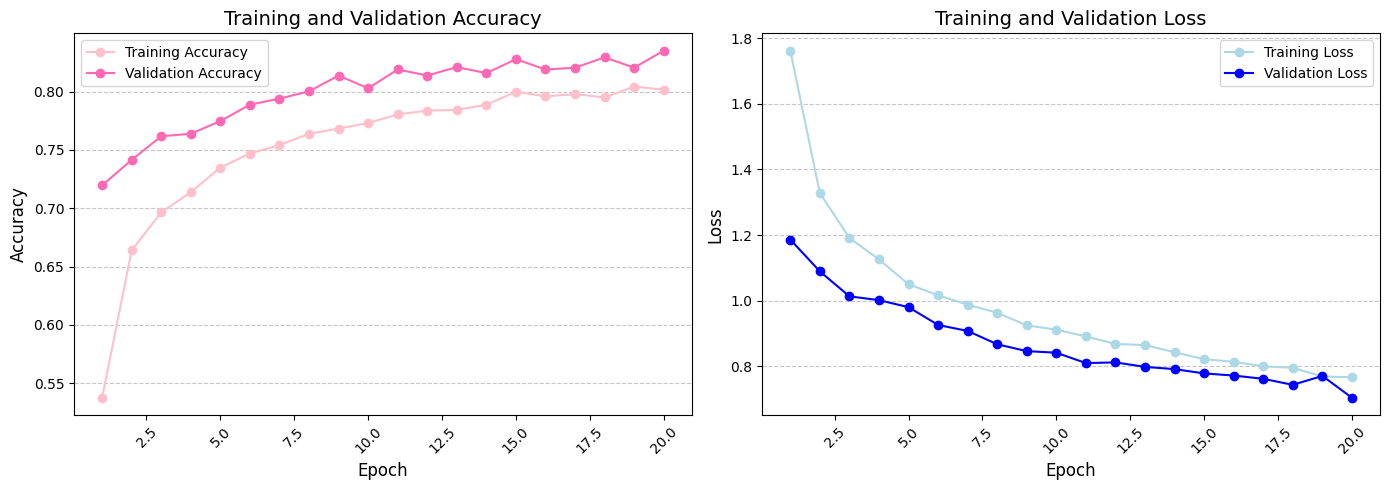

In [ ]:
plot_history(densenet_hist)

5.4. Experiment with data augmentation

In [ ]:
# load DenseNet121 model
augmented_model = DenseNet121(weights='imagenet',
                              include_top=False,
                              input_shape=(img_height, img_width, 3))

for layer in augmented_model.layers:
  layer.trainable = False

inputs = Input(shape=(img_height, img_width, 1))

# apply data augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02),
    RandomZoom(0.05)
])
augmented_inputs = data_augmentation(inputs)

# convert the grayscale to pseudo 3D images
pseudo_rgb = Lambda(lambda image: tf.image.grayscale_to_rgb(image))(augmented_inputs)

# add feature extractor
x = GlobalAveragePooling2D()(augmented_model(pseudo_rgb))

# add fully connected layers

# 1st dense layer
dense1 = Dense(512, activation='relu',
               kernel_regularizer=regularizers.l2(0.0001))(x)
dense1 = BatchNormalization()(dense1)
dense1 = Dropout(0.25)(dense1)

# 2nd dense layer
dense2 = Dense(448, activation='relu',
               kernel_regularizer=regularizers.l2(0.0001))(dense1)
dense2 = BatchNormalization()(dense2)
dense2 = Dropout(0.2)(dense2)

# 3rd dense layer
dense3 = Dense(256, activation='relu',
               kernel_regularizer=regularizers.l2(0.0001))(dense2)
dense3 = BatchNormalization()(dense3)
dense3 = Dropout(0.15)(dense3)

# output Layer
output = Dense(6, activation='softmax')(dense3)

# define a new model
new_model_2 = Model(inputs=inputs, outputs=output)

# compile the model
new_model_2.compile(optimizer=Adam(learning_rate=0.0002),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# print model summary
new_model_2.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)          │ (None, 72, 128, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_5 (Sequential)            │ (None, 72, 128, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_6 (Lambda)                    │ (None, 72, 128, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 2, 4, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 448)                 │         229,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 448)                 │           1,792 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 448)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 256)                 │         114,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,913,478 (30.19 MB)

 Trainable params: 873,542 (3.33 MB)

 Non-trainable params: 7,039,936 (26.86 MB)

In [ ]:
# train the model
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=3,
                              verbose=1)

augmented_hist = new_model_2.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[reduce_lr]
    )

Epoch 1/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 50s 91ms/step - accuracy: 0.3874 - loss: 1.9356 - val_accuracy: 0.6660 - val_loss: 1.1575 - learning_rate: 2.0000e-04
Epoch 2/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - accuracy: 0.6131 - loss: 1.2634 - val_accuracy: 0.7092 - val_loss: 1.0039 - learning_rate: 2.0000e-04
Epoch 3/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 29s 78ms/step - accuracy: 0.6709 - loss: 1.0594 - val_accuracy: 0.7268 - val_loss: 0.9062 - learning_rate: 2.0000e-04
Epoch 4/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.6928 - loss: 0.9763 - val_accuracy: 0.7253 - val_loss: 0.8774 - learning_rate: 2.0000e-04
Epoch 5/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 28s 76ms/step - accuracy: 0.7102 - loss: 0.9096 - val_accuracy: 0.7607 - val_loss: 0.7968 - learning_rate: 2.0000e-04
Epoch 6/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 29s 76ms/step - accuracy: 0.7112 - loss: 0.8961 - val_accuracy: 0.7451 - val_loss: 0.8437 - learning_rate: 2.0000e-04
Epoch 7/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/ste

In [ ]:
# test the accuracy on test set
augmented_loss, augmented_acc = new_model_2.evaluate(test_data, verbose=0)
print(f"Test Accuracy: {augmented_acc:.4f}")

Test Accuracy: 0.7939


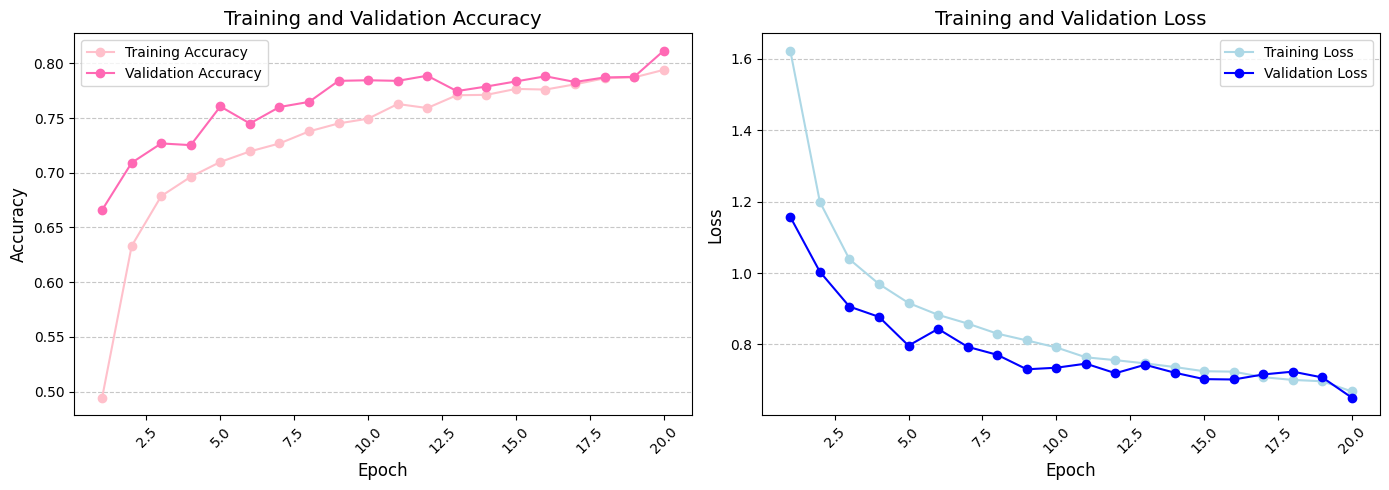

In [ ]:
# plot the accuracy and loss on training and validation sets
plot_history(augmented_hist)

5.5. Evaluate the new model

In [ ]:
# Retrieve true labels and class names
y_test_true_int = test_data.labels
class_names = [k for k, v in sorted(test_data.class_indices.items(), key=lambda item: item[1])]
n_classes = len(class_names)

# Predict class probabilities & binarize true labels
y_test_pred_probs = new_model.predict(test_data)
y_test_pred_int = np.argmax(y_test_pred_probs, axis=1)
y_test_true_bin = label_binarize(y_test_true_int, classes=range(n_classes))

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


In [ ]:
# Compute evaluation metrics
test_accuracy = accuracy_score(y_test_true_int, y_test_pred_int)
test_precision = precision_score(y_test_true_int, y_test_pred_int, average='weighted')
test_recall = recall_score(y_test_true_int, y_test_pred_int, average='weighted')
test_f1 = f1_score(y_test_true_int, y_test_pred_int, average='weighted')

# Print results
print("\n--- Test Set Performance: ---")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"F1 Score: {test_f1:.2f}")


--- Test Set Performance: ---
Accuracy: 0.82
Precision: 0.82
Recall: 0.82
F1 Score: 0.81


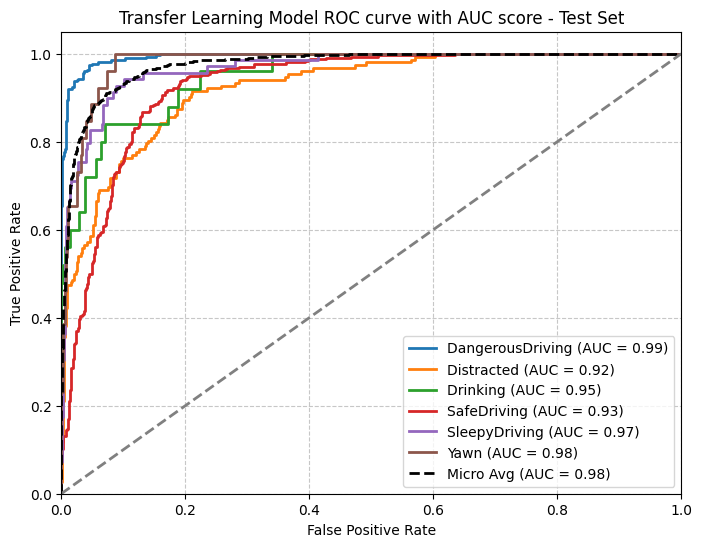

In [ ]:
# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_true_bin[:, i], y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_true_bin.ravel(), y_test_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC Curves
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    plt.plot(fpr[i],
             tpr[i],
             lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:0.2f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"],
         tpr["micro"],
         linestyle='--',
         lw=2,
         color='black',
         label=f'Micro Avg (AUC = {roc_auc["micro"]:0.2f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Transfer Learning Model ROC curve with AUC score - Test Set')
plt.legend(loc="lower right")
plt.grid(alpha=0.7, linestyle='--')
plt.savefig('Transfer Learning Model ROC curve with AUC score.png', dpi=300)
plt.show()

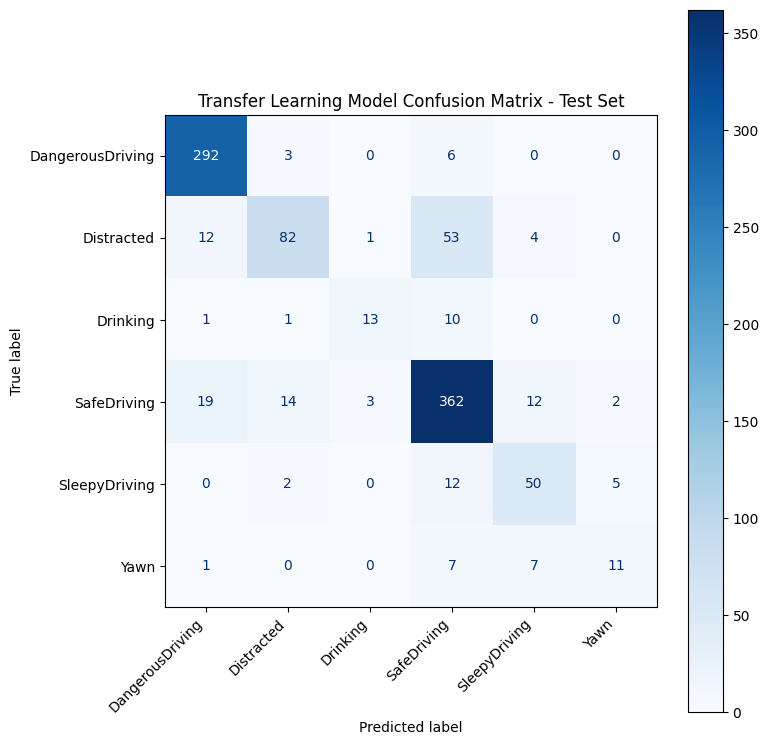

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test_true_int, y_test_pred_int)

# Create the figure and plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp_test.plot(cmap=plt.cm.Blues, ax=ax)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.title('Transfer Learning Model Confusion Matrix - Test Set')

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('Transfer Learning Model Confusion Matrix.png', dpi=300)
plt.show()

The transfer learning model outperformed the baseline model in all metrics of performance measures, including accuracy, precision, recall, and F1 score. However, it did not surpass the optimized model with medium layers in performance measures. For this specific classification task, the consequences of misclassifying dangerous driving and other distraction behaviors are more severe than failing to identify safe driving. Thus, the class-wise performance is particularly important. While the baseline model frequently misclassified dangerous driving as safe driving and struggled significantly with the distracted category (AUC=0.79), the transfer learning model had higher consistency. It was particularly effective in spotting dangerous driving (AUC=0.99). The optimized model also had a balanced performance across all classes, however, the performance gaps between classes are more evident than the transfer learning model.

In [ ]:
# download the figures
files.download('Transfer Learning Model ROC curve with AUC score.png')
files.download('Transfer Learning Model Confusion Matrix.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>